# Dataset Cleaning

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import math
import string
import requests
from itertools import product
from inspect import getsourcefile

os.chdir('\\\\file/UsersM$/mwa150/Home/Desktop/Ele.candidates.senators')
pd.set_option('display.max_colwidth', -1)
All_df = pd.read_csv('original_106json.csv', encoding = 'utf-8')

# tweets date from 29Oct - 06Nov 2018
All_df['created_at'] = pd.to_datetime(All_df.created_at).dt.date
All_df['created_at'] = pd.to_datetime(All_df.created_at, errors='coerce')
All_df = All_df.loc[(All_df['created_at'] >= '2018-10-09') & (All_df['created_at'] <= '2018-12-04')]

# language is English 
All_df = All_df.loc[All_df['lang'] == 'en']

# remove RT and reply tweets
All_df = All_df[All_df['in_reply_to_screen_name'].isnull()]

# extract elements from dataframe 
col_to_keep = ['created_at', 'full_text', 'retweet_count', 'user']
All_df = All_df[col_to_keep]

add_followers = []
add_listed = []
add_screename = []

for index, row in All_df.iterrows():
    fo = (row['user']['followers_count'])
    li = (row['user']['listed_count'])
    sc = (row['user']['screen_name'])
    
    add_followers.append(fo)
    add_listed.append(li)
    add_screename.append(sc)

All_df['followers_count'] = add_followers
All_df['listed_count'] = add_listed
All_df['screen_name'] = add_screename
del All_df['user']

# Text Cleaning

One of the 1st steps in working with twitter text is to pre-process it. The most of text data is highly unstructured and noisy - to achieve better insights or to build better algorithms, it is necessary to play with clean data.

In [ ]:
import string
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

split_adhere_dic = {"cause": "because", "could've": "could have",
                    "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                    "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                    "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                    "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                    "i'll've": "i will have","i'm": "i am", "i've": "i have",
                    "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                    "it'll've": "it will have","it's": "it is", 
                    "let's": "let us", "ma'am": "madam", "might've": "might have",
                    "o'clock": "of the clock", 
                    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                    "she'll've": "she will have", "she's": "she is", "should've": "should have",
                    "so've": "so have","so's": "so as", 
                    "this's": "this is",
                    "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                    "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                    "here's": "here is",
                    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                    "they'll've": "they will have", "they're": "they are", "they've": "they have",
                    "to've": "to have", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                    "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                    "what's": "what is", "what've": "what have", "when's": "when is", 
                    "when've": "when have", "where'd": "where did", "where's": "where is", 
                    "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                    "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "would've": "would have",
                    "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                    "y'all're": "you all are","y'all've": "you all have", "you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", 
                    "you'll've": "you will have", "you're": "you are", "you've": "you have",
                    "is not": "ain't", "are not": "aren't","cannot": "can't", "can not": "can't", 
                    "cannot have": "can't've", "could not": "couldn't", "could not have": "couldn't've","did not": "didn't", 
                    "does not": "doesn't", "do not": "don't", "had not": "hadn't",  
                    "had not have": "hadn't've", "has not": "hasn't", "have not": "haven't", "is not": "isn't", 
                    "may not": "mayn't", "might not": "mightn't","might not have": "mightn't've", 
                    "must have": "must've", "must not": "mustn't", "must not have": "mustn't've", 
                    "need not": "needn't", "need not have": "needn't've",
                    "ought not": "oughtn't", "ought not have": "oughtn't've", "shall not": "shan't",
                    "shall not": "sha'n't", "shall not have": "shan't've", 
                    "should not": "shouldn't", "should not have": "shouldn't've", "was not": "wasn't", "were not": "weren't",
                    "will not": "won't", "will not have": "won't've",  "would not": "wouldn't", 
                    "would not have": "wouldn't've", 
                    "no prblme": "noproblem", "no prob": "noprob", "no problems": "noproblmes", "no probs": "noprobs",
                    "no worry": "noworry", "no worries": "noworries", "good bey": "goodbey", "long time no see": "longtimenosee", 
                    "nothing but": "nothingbut", "no more": "nomore",
                    "kind of": "kindof", "sort of": "sortof"}

pat1 = r'@[\w_]+' # @-mention
pat2 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+' # URLs
pat5 = r'www.[^ ]+' # additions to URLs, texts with 'www..'
combined_pat = r'|'.join((pat1, pat2, pat5))
split_pattern = re.compile(r'\b(' + '|'.join(split_adhere_dic.keys()) + r')\b')

def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    split_handled = split_pattern.sub(lambda x: split_adhere_dic[x.group()], stripped)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', split_handled)
    return spell_corrected

All_df.dropna(inplace=True)
All_df['clean_text'] = [tweet_cleaner(t) for t in All_df.full_text]
All_df.to_csv('politicians_clean.csv', encoding = 'utf-8')

# VaderSentiment

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It is fully open-sourced under the [MIT License]. https://github.com/cjhutto/vaderSentiment

In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

All_df = pd.read_csv('politicians_clean.csv',index_col=0)
All_df.dropna(inplace=True)
vader = All_df['clean_text'].apply(lambda x : analyzer.polarity_scores(x))
All_df = pd.concat([All_df,vader.apply(pd.Series)],1)

# positive versus negative tweets
All_df['valence'] = ''
All_df['valence'] = np.where(All_df['compound'] > 0, All_df['valence'], 'Negative')
All_df['valence'].replace('','Positive', inplace=True)

col_to_keep = ['created_at', 'full_text', 'clean_text', 'screen_name', 'followers_count', 'retweet_count', 'compound', 'valence']
All_df = All_df[col_to_keep]
All_df.to_csv('politicians_vader.csv', encoding = 'utf-8')
All_df.head(3)

,created_at,full_text,clean_text,screen_name,followers_count,retweet_count,compound,valence
0,2018-12-03,"Defense Sec Mattis has confirmed that Russia tried to interfere in our 2018 elections. Make no mistake, they will continue to do this. We must pass my Secure Elections Act before it’s too late.\nhttps://t.co/8YpB0MHISJ","Defense Sec Mattis has confirmed that Russia tried to interfere in our 2018 elections. Make no mistake, they will continue to do this. We must pass my Secure Elections Act before it’s too late.\n",amyklobuchar,523108,2830,-0.1779,Negative
1,2018-12-03,"With alarming new information coming out about climate change, it’s encouraging to see Minnesotans like @EricDayton and @willsteger are working to “Keep the North Cold.”\nhttps://t.co/4liTVdn08S","With alarming new information coming out about climate change, it’s encouraging to see Minnesotans like and are working to “Keep the North Cold.”\n",amyklobuchar,523108,63,0.6597,Positive
2,2018-12-03,"Children of parents addicted to opioids are being placed into foster care at crisis levels. This is affecting families in every community, every day. We need to get those addicted the help they need.\nhttps://t.co/PsV56uIHyR","Children of parents addicted to opioids are being placed into foster care at crisis levels. This is affecting families in every community, every day. We need to get those addicted the help they need.\n",amyklobuchar,523108,92,0.2023,Positive


## Heatmap 

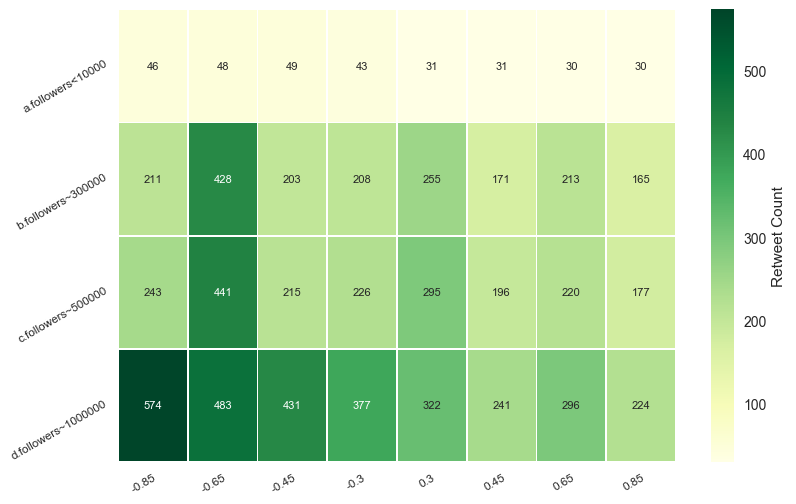

In [4]:
df = pd.read_csv('heatmap_followers_10000.csv')

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('heatmap_followers_10000.csv')
flights = df.pivot("followers_group", "intensity_group", "retweet_count")
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
sns.heatmap(flights, 
            annot=True, fmt='g',
            annot_kws={"size": 8},
            linewidths=0.5, ax=ax, cmap="YlGn", 
            cbar_kws={'label': 'Retweet Count', "shrink": 1.0})
ax.set_ylabel('')    
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor", size = 8.5)
plt.setp(ax.get_yticklabels(), rotation=30, ha="right", rotation_mode="anchor", size = 8.5)
plt.show()

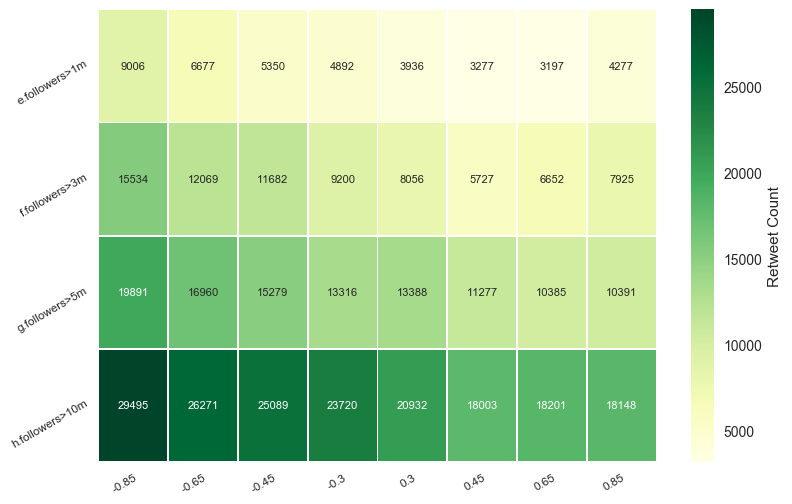

In [5]:
df = pd.read_csv('heatmap_followers_1m.csv')

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('heatmap_followers_1m.csv')
flights = df.pivot("followers_group", "intensity_group", "retweet_count")
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
sns.heatmap(flights, 
            annot=True, fmt='g',
            annot_kws={"size": 8},
            linewidths=0.5, ax=ax, cmap="YlGn", 
            cbar_kws={'label': 'Retweet Count', "shrink": 1.0})
ax.set_ylabel('')    
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor", size = 8.5)
plt.setp(ax.get_yticklabels(), rotation=30, ha="right", rotation_mode="anchor", size = 8.5)
plt.show()

# WordCloud

In [6]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

All_df = pd.read_csv('politicians_vader.csv', encoding = 'utf-8')
All_df['valence'] = ''
All_df['valence'] = np.where(All_df['compound'] > 0, All_df['valence'], 'Negative')
All_df['valence'].replace('','Positive', inplace=True)
All_df.dropna(inplace=True)

neg_df = All_df[All_df.valence == 'Negative']
pos_df = All_df[All_df.valence == 'Positive']

neg_df = neg_df[neg_df['compound'] <= -0.70]
pos_df = pos_df[pos_df['compound'] >= 0.70]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mwa150\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


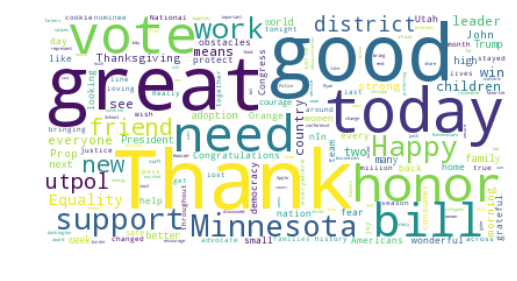

In [7]:
pos_tex = str(pos_df['clean_text'])

stopwords.update(["https", "amp", "http", "co", 
                  "us", "American", "one", 'America',
                  "year", "people", 'time', 'years'])

wordcloud1 = WordCloud(stopwords=stopwords, background_color="white", max_font_size=70).generate(pos_tex)
plt.figure(figsize=(6,4), dpi=100)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
# plt.show()
plt.savefig('word_cloud_pos.png')

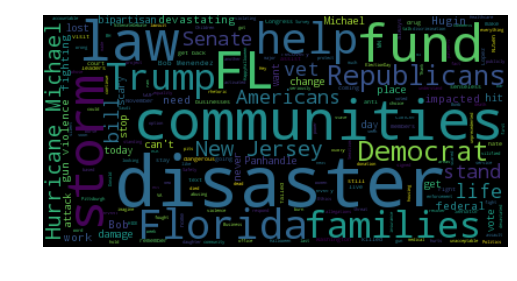

In [11]:
neg_tex = str(neg_df['clean_text'])

wordcloud2 = WordCloud(stopwords=stopwords, background_color="black", max_font_size=60).generate(neg_tex)
plt.figure(figsize=(6,4), dpi=100)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
# plt.show()
plt.savefig('word_cloud_neg.png')